# Historical distribution: Forecast

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [3]:
NUM_SAMPLES = 1000
HORIZON = 4

# Load data

In [5]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [7]:
forecast_date = forecast_dates[25]

In [66]:
forecast_week = pd.Timestamp(forecast_date).isocalendar().week

In [121]:
targets, _ = load_realtime_training_data(forecast_date)

In [127]:
df = targets.pd_dataframe()

In [126]:
age_groups = ['DE', '00-04', '05-14', '15-34', '35-59', '60-79', '80+']

In [129]:
df.columns

Index(['icosari-sari-DE', 'icosari-sari-00-04', 'icosari-sari-05-14',
       'icosari-sari-15-34', 'icosari-sari-35-59', 'icosari-sari-60-79',
       'icosari-sari-80+'],
      dtype='object', name='component')

In [130]:
age = '00-04'

In [132]:
col = f'icosari-sari-{age}'

In [134]:
df = targets[col].pd_dataframe().reset_index()

In [135]:
df['week'] = df['date'].dt.isocalendar().week

In [150]:
df['age_group'] = age

In [136]:
df = df.rename(columns={col: 'value'})

In [137]:
df

component,date,value,week
0,2014-10-05,1340.0,40
1,2014-10-12,1190.0,41
2,2014-10-19,1585.0,42
3,2014-10-26,1680.0,43
4,2014-11-02,1510.0,44
...,...,...,...
492,2024-03-10,2633.0,10
493,2024-03-17,2222.0,11
494,2024-03-24,2206.0,12
495,2024-03-31,2076.0,13


In [138]:
from scipy.stats import nbinom

In [139]:
# Function to fit a negative binomial distribution
def fit_negative_binomial(values):
    mean = np.mean(values)
    var = np.var(values)
    if var > mean:  # Ensure valid parameters
        p = mean / var
        r = mean ** 2 / (var - mean)
        return r, p
    else:
        return None, None  # Return None if not valid

In [156]:
df.age_group.unique()[0]

'00-04'

In [162]:
def forecast_historical_average(df, forecast_date, window=2, quantiles=[0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]):
    forecast_date = pd.Timestamp(forecast_date)
    iso_week = forecast_date.isocalendar().week
    
    long_format_results = []

    # Generate forecasts for the next 4 weeks
    for horizon in range(1, 5):
        target_week = (iso_week + horizon) % 53 or 53  # Handle ISO week wraparound

        # Filter data for the target week and neighboring weeks
        weeks = list(range(target_week - window, target_week + window + 1))
        week_data = df[df['week'].isin(weeks)]['value']
        
        # Fit Negative Binomial distribution
        r, p = fit_negative_binomial(week_data)
        if r is not None and p is not None:
            # Compute quantiles from the Negative Binomial distribution
            dist = nbinom(r, p)
            quantile_values = dist.ppf(quantiles)
        else:
            # If parameters are invalid, return NaNs for quantiles
            quantile_values = [np.nan] * len(quantiles)
        
        # Transform week back to a date
        target_end_date = pd.Timestamp.fromisocalendar(forecast_date.year, target_week-1, 7)
        
        # Add rows in long format
        for quantile, value in zip(quantiles, quantile_values):
            long_format_results.append({
                'location' : 'DE',
                'age_group' : df.age_group.unique()[0],
                'forecast_date' : forecast_date,
                'target_end_date': target_end_date,
                'horizon': horizon,
                'type' : 'quantile',
                'quantile': quantile,
                'value': value
            })
    
    # Convert to DataFrame
    return pd.DataFrame(long_format_results)

In [163]:
forecast_date = forecast_dates[25]

In [164]:
forecast = forecast_historical_average(df, forecast_date, window=1)

In [165]:
forecast_date

'2024-05-09'

In [181]:
def compute_historical_average(forecast_date):
    age_groups = ['DE', '00-04', '05-14', '15-34', '35-59', '60-79', '80+']
    
    targets, _ = load_realtime_training_data(forecast_date)
    df = targets.pd_dataframe()

    forecasts = pd.DataFrame()
    for age in age_groups:
        col = f'icosari-sari-{age}'
        df_temp = targets[col].pd_dataframe().reset_index()
        df_temp['week'] = df_temp['date'].dt.isocalendar().week
        df_temp['age_group'] = '00+' if age == 'DE' else age
        df_temp = df_temp.rename(columns={col: 'value'})
        forecast = forecast_historical_average(df_temp, forecast_date, window=1)
        forecasts = pd.concat([forecasts, forecast], ignore_index=True)
    return forecasts

In [182]:
forecast_date

'2024-11-14'

In [183]:
compute_historical_average(forecast_date)

,location,age_group,forecast_date,target_end_date,horizon,type,quantile,value
0,DE,00+,2024-11-14,2024-11-17,1,quantile,0.025,4714.0
1,DE,00+,2024-11-14,2024-11-17,1,quantile,0.100,6692.0
2,DE,00+,2024-11-14,2024-11-17,1,quantile,0.250,8902.0
3,DE,00+,2024-11-14,2024-11-17,1,quantile,0.500,11893.0
4,DE,00+,2024-11-14,2024-11-17,1,quantile,0.750,15493.0
...,...,...,...,...,...,...,...,...
191,DE,80+,2024-11-14,2024-12-08,4,quantile,0.250,2953.0
192,DE,80+,2024-11-14,2024-12-08,4,quantile,0.500,3965.0
193,DE,80+,2024-11-14,2024-12-08,4,quantile,0.750,5187.0
194,DE,80+,2024-11-14,2024-12-08,4,quantile,0.900,6478.0


In [170]:
df.to_csv(f'../data/post-covid/submissions/baseline/{forecast_date}-icosari-sari-baseline.csv', index=False)

In [184]:
for forecast_date in forecast_dates[7:]:
    print(forecast_date)
    forecast = compute_historical_average(forecast_date)
    forecast.to_csv(f'../data/post-covid/submissions/baseline/{forecast_date}-icosari-sari-baseline.csv', index=False)

2024-01-04
2024-01-11
2024-01-18
2024-01-25
2024-02-01
2024-02-08
2024-02-15
2024-02-22
2024-02-29
2024-03-07
2024-03-14
2024-03-21
2024-03-28
2024-04-04
2024-04-11
2024-04-18
2024-04-25
2024-05-02
2024-05-09
2024-05-16
2024-05-23
2024-05-30
2024-06-06
2024-06-13
2024-06-20
2024-06-27
2024-07-04
2024-07-11
2024-07-18
2024-07-25
2024-08-01
2024-08-08
2024-08-15
2024-08-22
2024-08-29
2024-09-05
2024-09-12
2024-09-19
2024-09-26
2024-10-03
2024-10-10
2024-10-17
2024-10-24
2024-10-31
2024-11-07
2024-11-14


In [39]:
# Forecast function for historical average
def forecast_historical_average(data, target_week, window=2, num_samples=1000):
    forecast = []
    
    for stratum in data['stratum'].unique():
        # Filter data for the specific stratum
        stratum_data = data[data['stratum'] == stratum]
        
        # Filter data for the target week and neighboring weeks
        weeks = list(range(target_week - window, target_week + window + 1))
        week_data = stratum_data[stratum_data['week'].isin(weeks)]['value']
        
        # Fit Negative Binomial distribution
        r, p = fit_negative_binomial(week_data)
        if r is not None and p is not None:
            # Generate a forecast using the distribution
            dist = nbinom(r, p)
            samples = dist.rvs(size=num_samples)
            forecast.extend(samples)
        else:
            forecast.extend([np.nan] * len(week_data))  # Use NaN if invalid
    
    return forecast

In [9]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/post-covid_{NAME}-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, target_series, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{NAME}2/{forecast_date}-icosari-sari-{NAME}2.csv', index=False)
        return df
    else:
        return df

In [10]:
# df = compute_ensemble(forecast_dates[5])

In [ ]:
forecasts = []
for forecast_date in forecast_dates[4:]:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

2023-12-14
1
2
3
4
5
6
7
8
9
10
2023-12-21
1
2
3
4
5
6
7
8
9
10
2023-12-28
1
2
3
4
5
6
7
8
9
10
2024-01-04
1
2
3
4
5
6
7
8
9
10
2024-01-11
1
2
3
4
5
6
7
8
9
10
2024-01-18
1
2
3
4
5
6
7
8
9
10
2024-01-25
1
2
3
4
5
6
7
8
9
10
2024-02-01
1
2
3
4
5
6
7
8
9
10
2024-02-08
1
2
3
4
5
6
7
8
9
10
2024-02-15
1
2
3
4
5
6
7
8
9
10
2024-02-22
1
2
3
4
5
6
7
8
9
10
2024-02-29
1
2
3
4
5
6
7
8
9
10
2024-03-07
1
2
3
4
5
6
7
8
9
10
2024-03-14
1


# Plot forecasts

In [29]:
df = pd.concat(forecasts)

In [30]:
target_sari = load_target_series('sari')

In [31]:
df_plot = prepare_plot_data(df, target_sari)

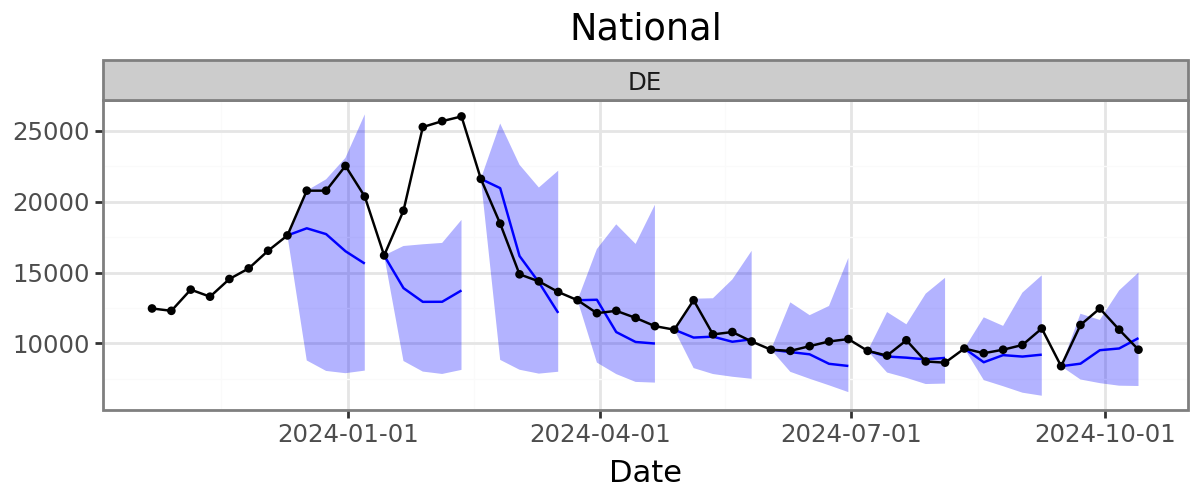

In [32]:
plot_forecasts(df_plot, 'national', start=0)

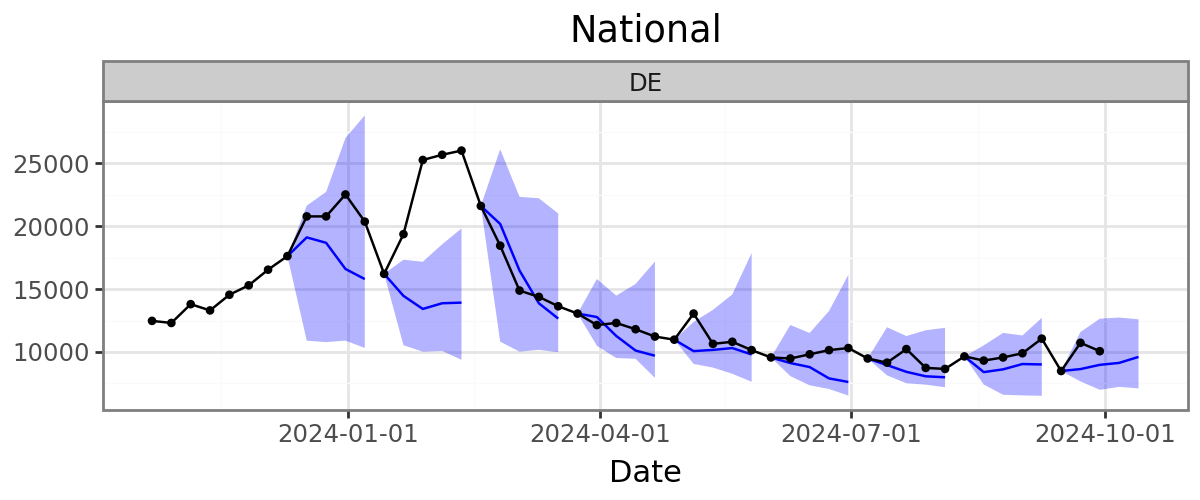

In [56]:
plot_forecasts(df_plot, 'national', start=0)

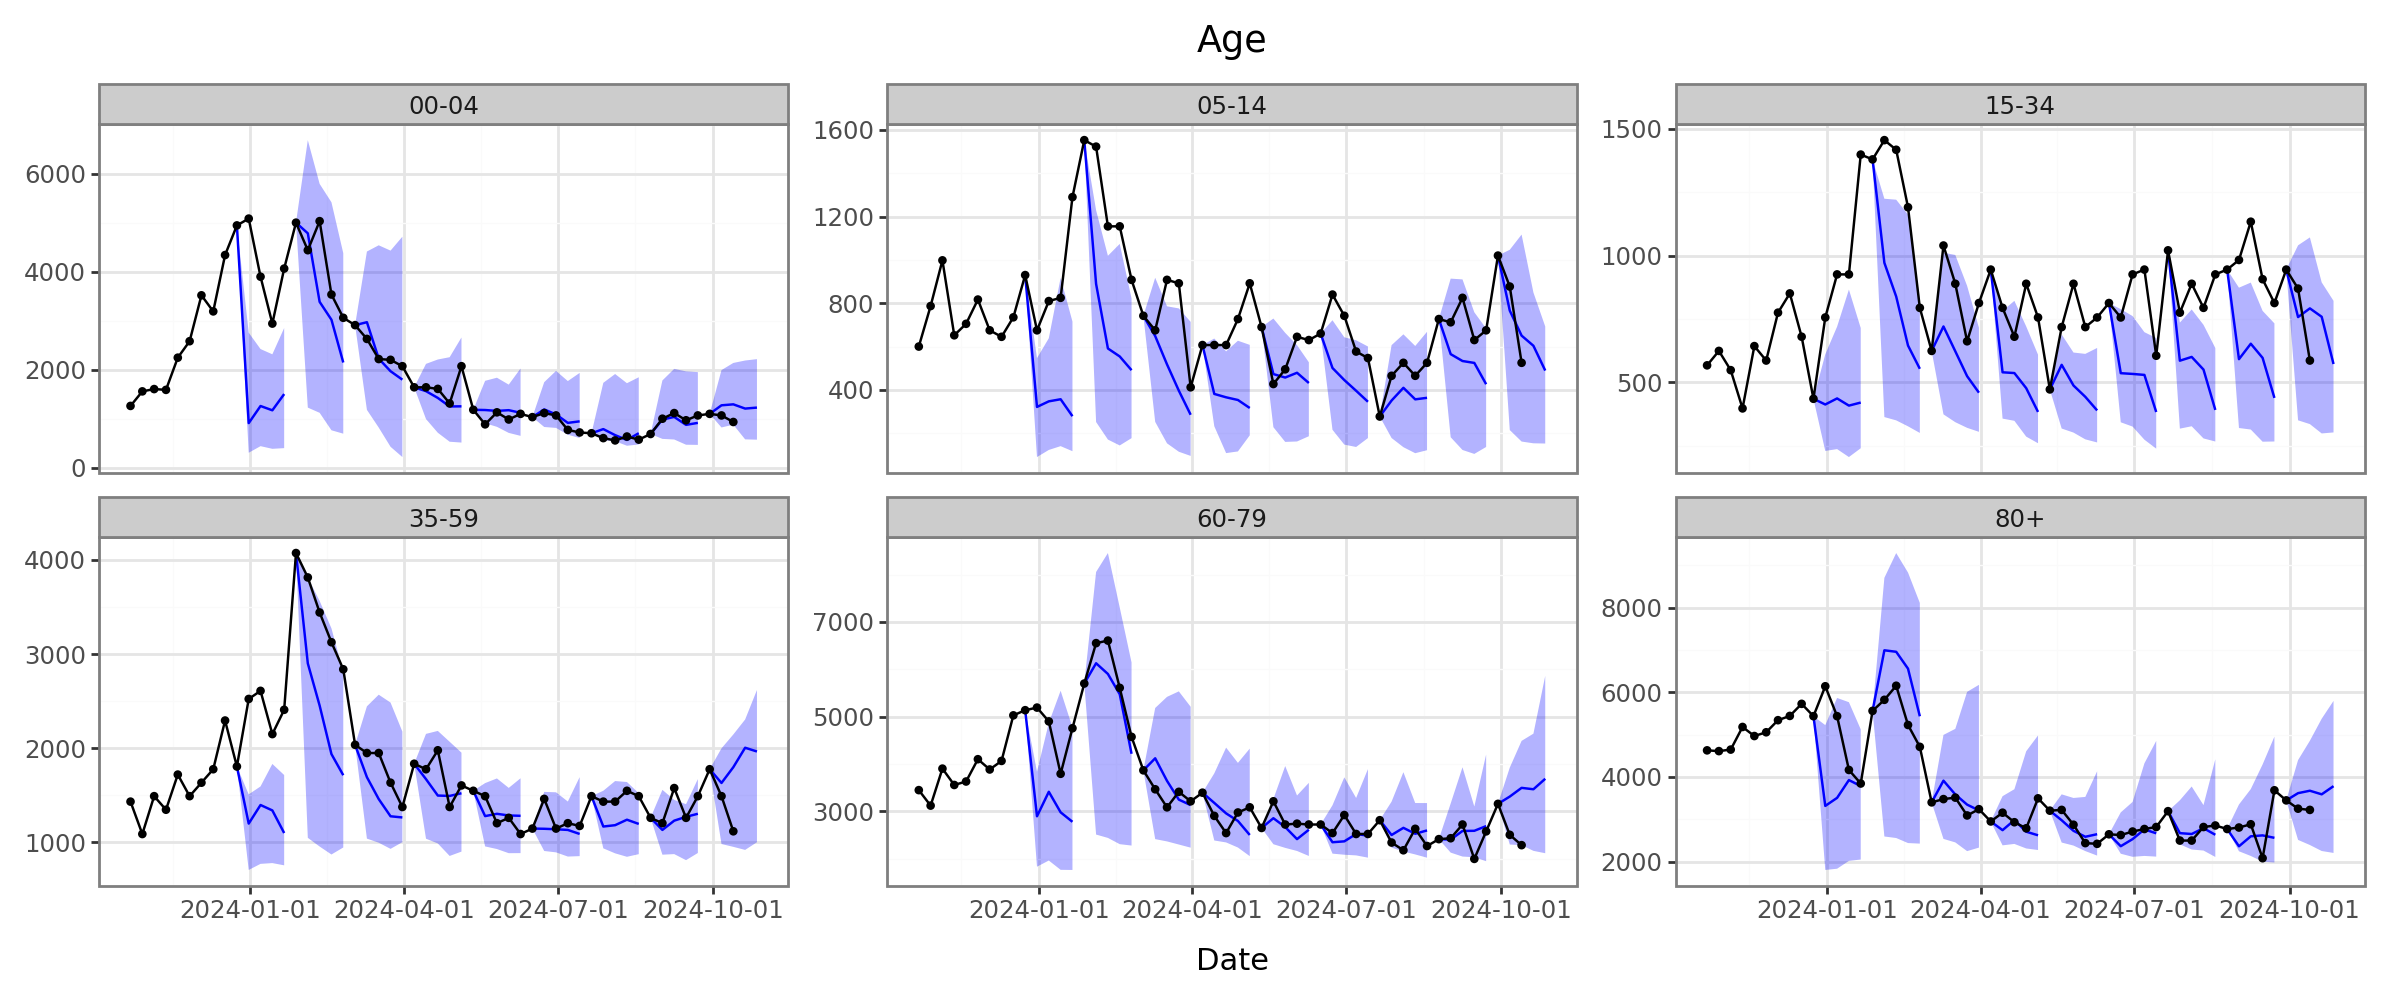

In [37]:
plot_forecasts(df_plot, 'age', start=2)

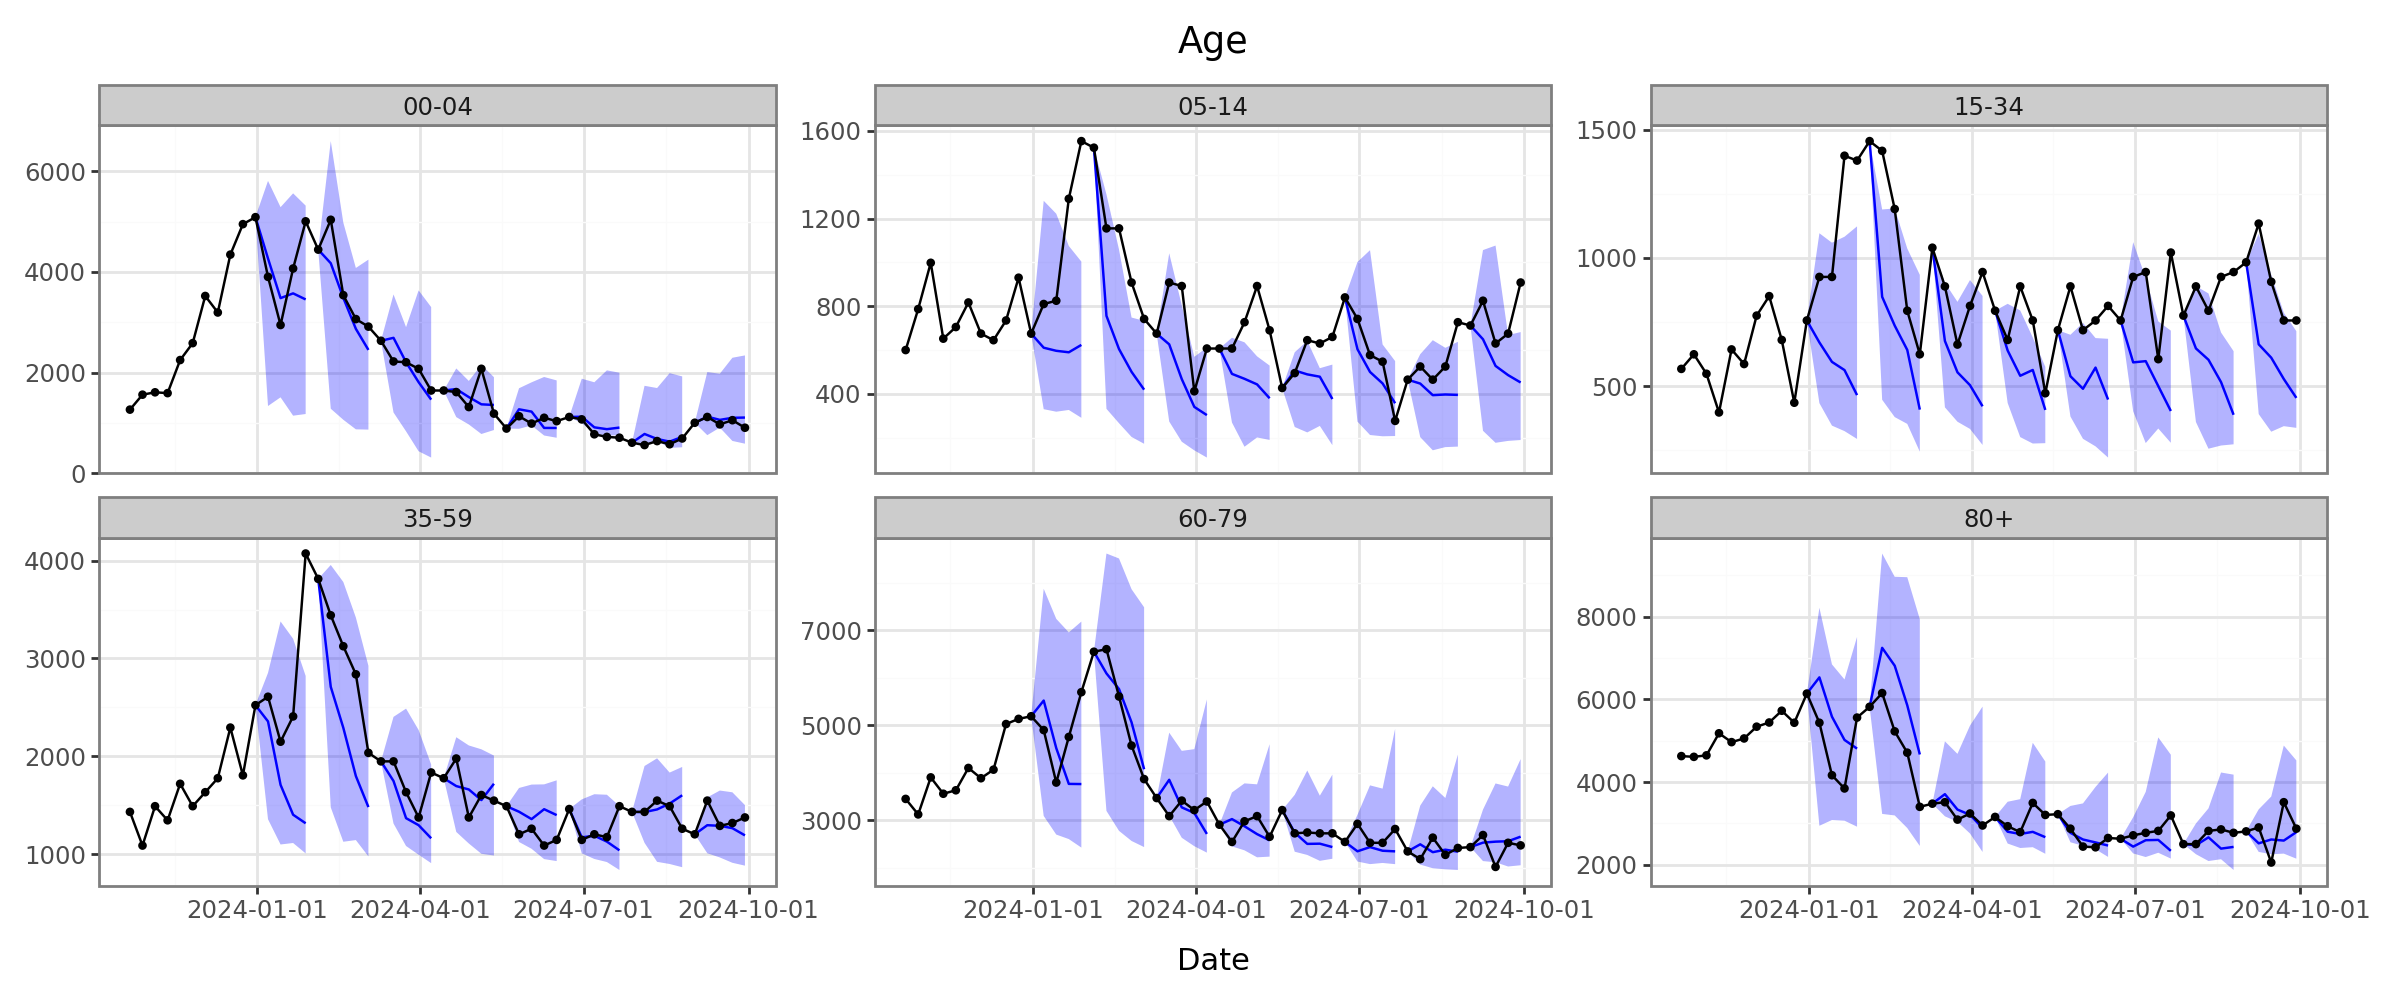

In [75]:
plot_forecasts(df_plot, 'age', start=3)

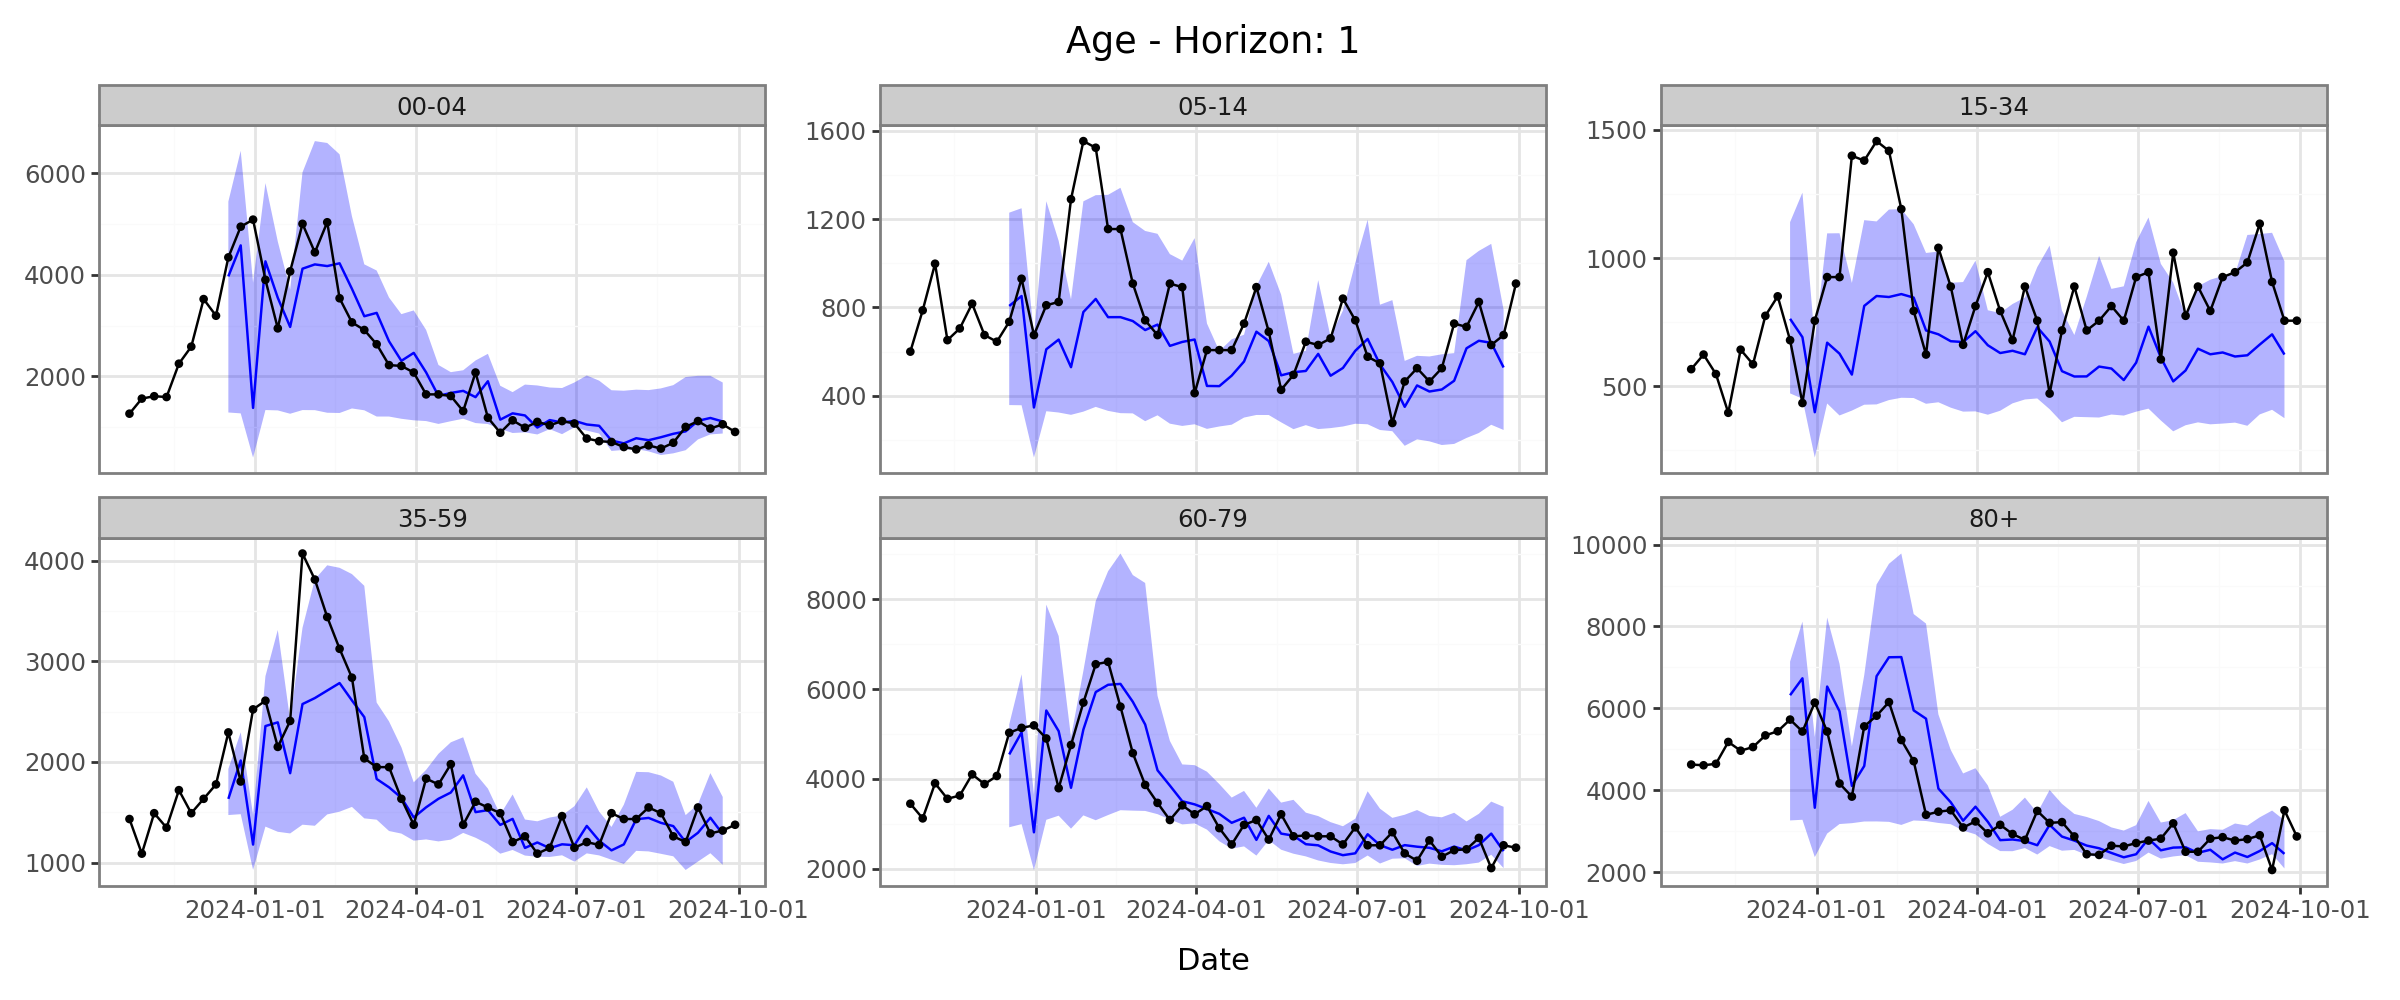

In [69]:
plot_forecasts(df_plot, 'age', horizon=1)

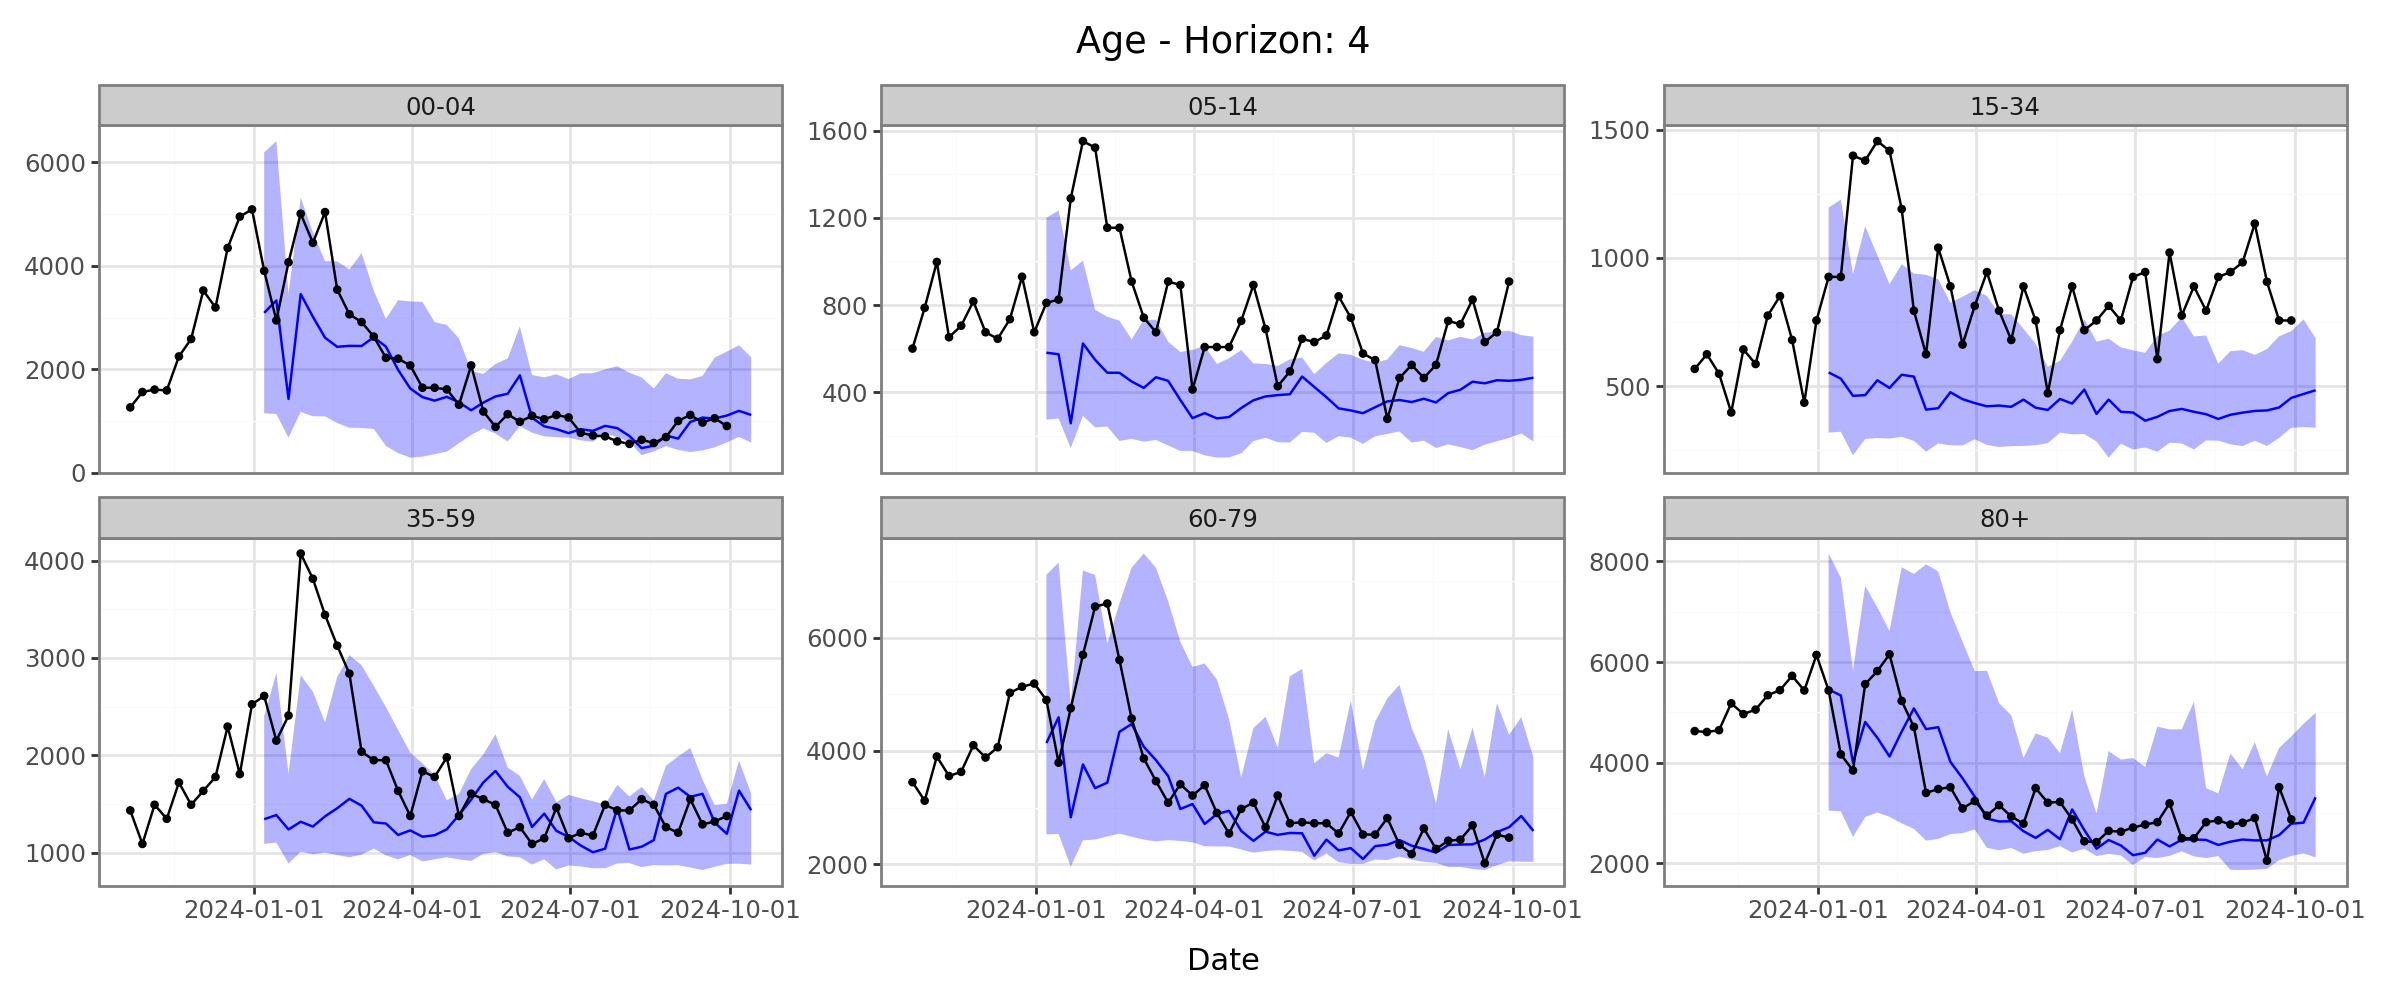

In [61]:
plot_forecasts(df_plot, 'age', horizon=4)

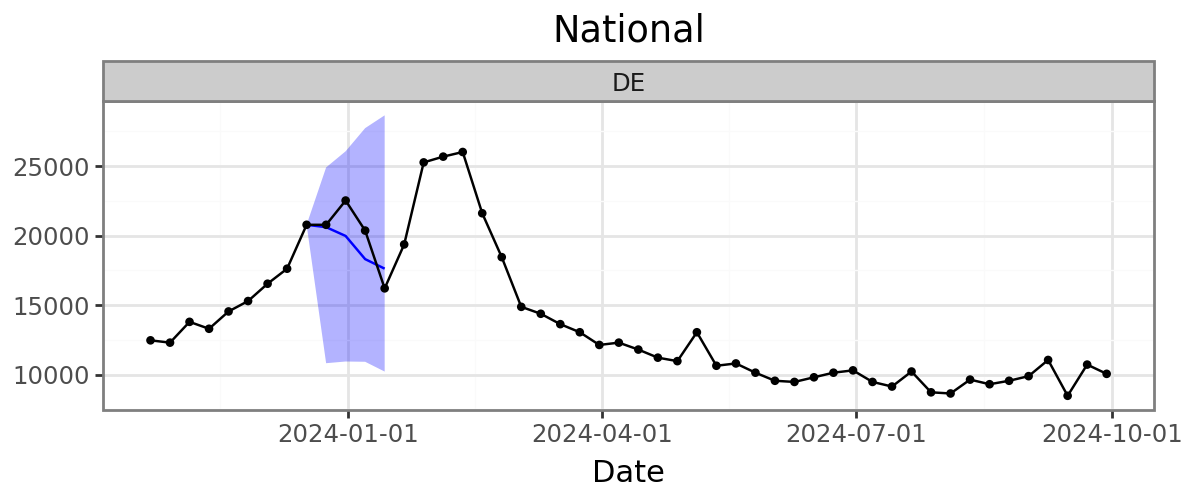

In [42]:
plot_forecasts(df_plot, 'national', start=0)

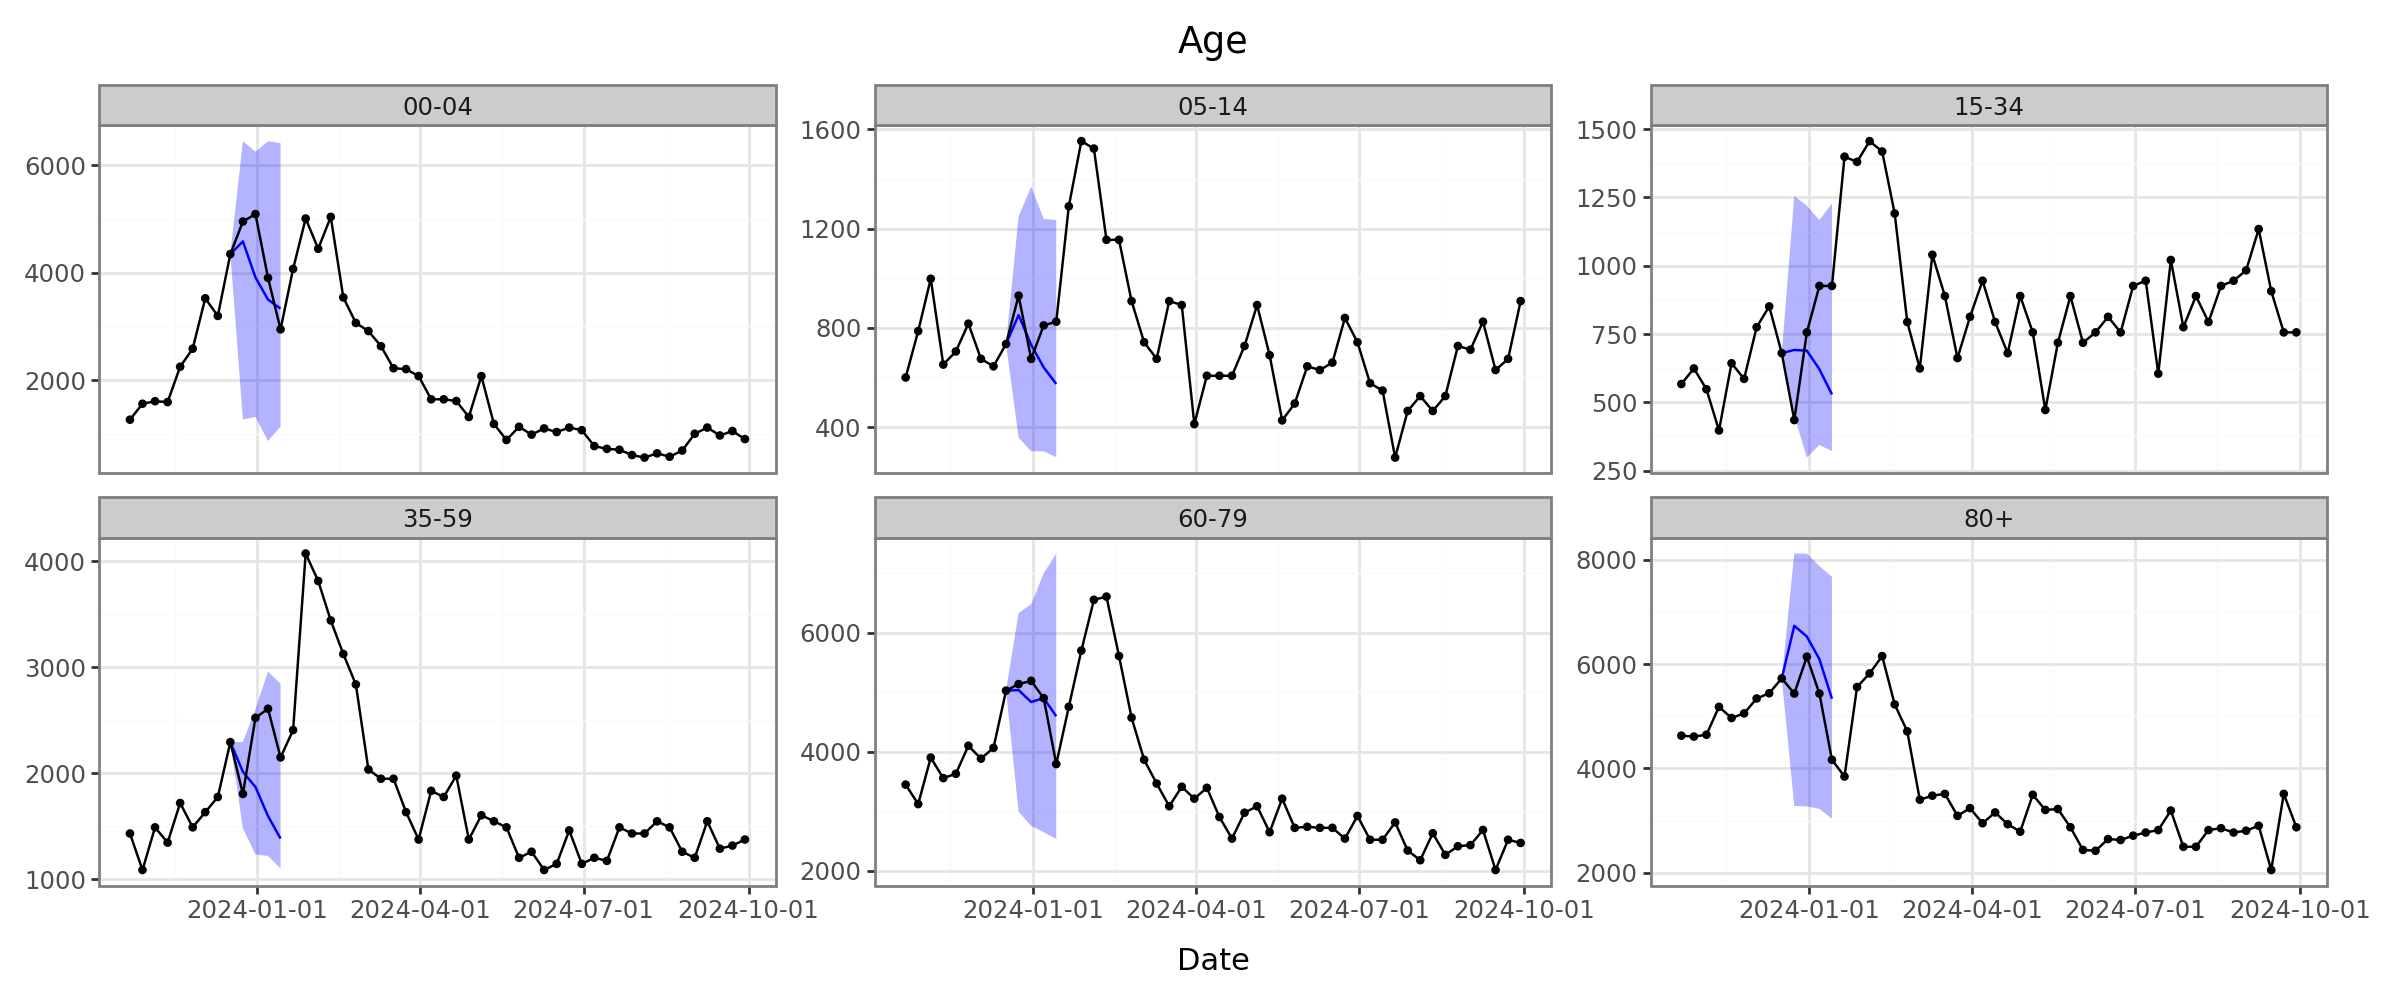

In [43]:
plot_forecasts(df_plot, 'age', start=0)

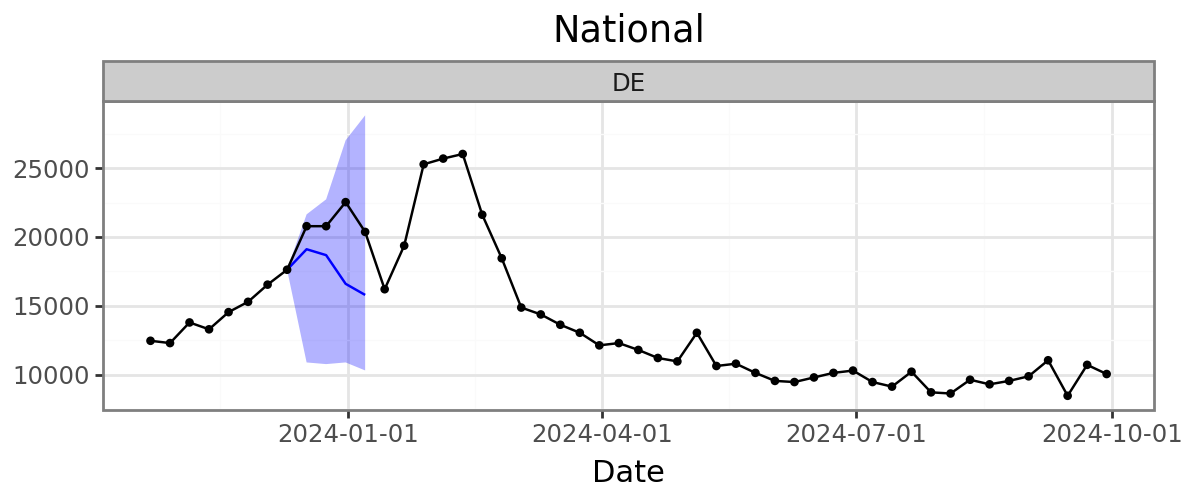

In [37]:
plot_forecasts(df_plot, 'national', start=0)

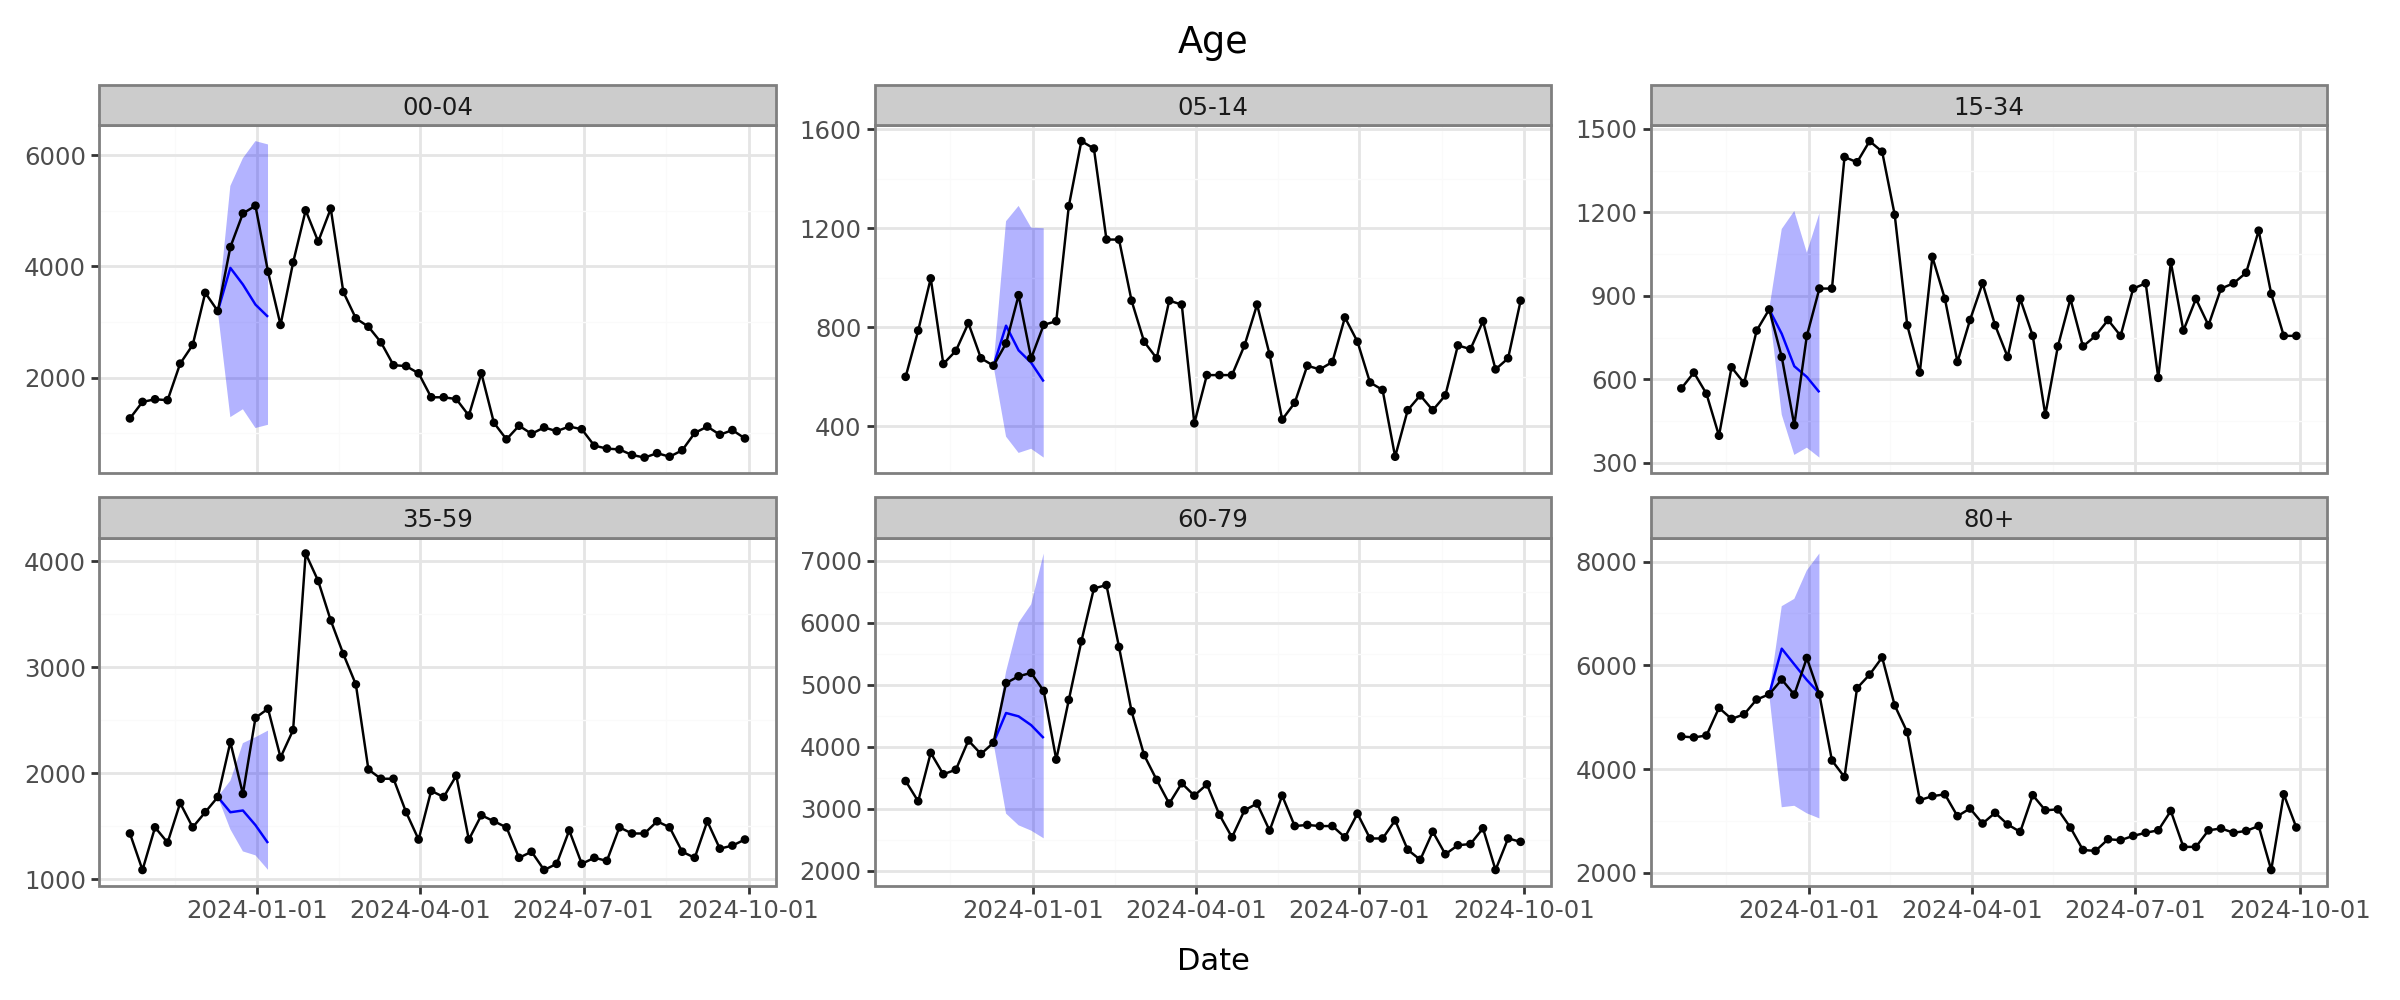

In [38]:
plot_forecasts(df_plot, 'age', start=0)

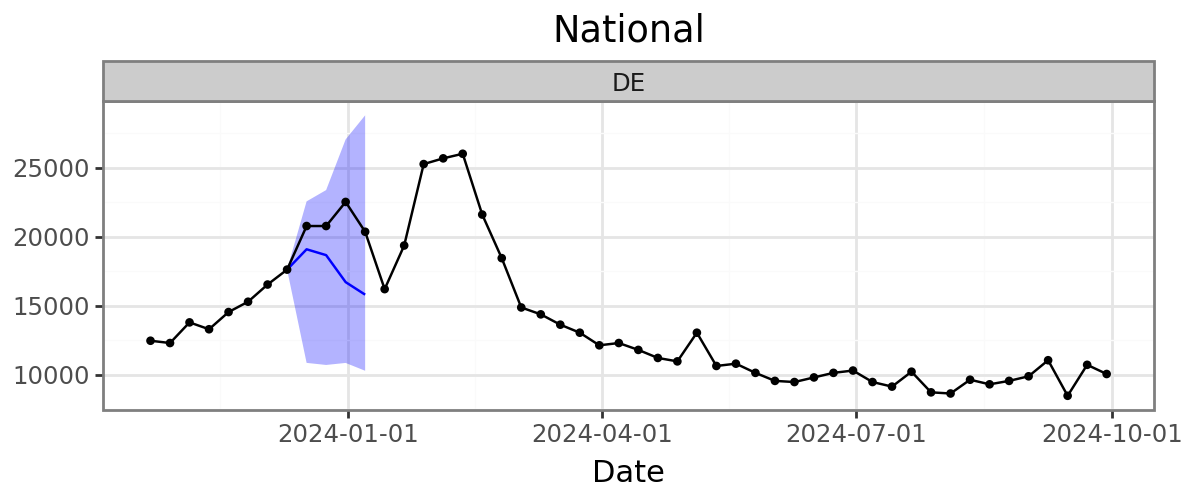

In [30]:
plot_forecasts(df_plot, 'national', start=0)

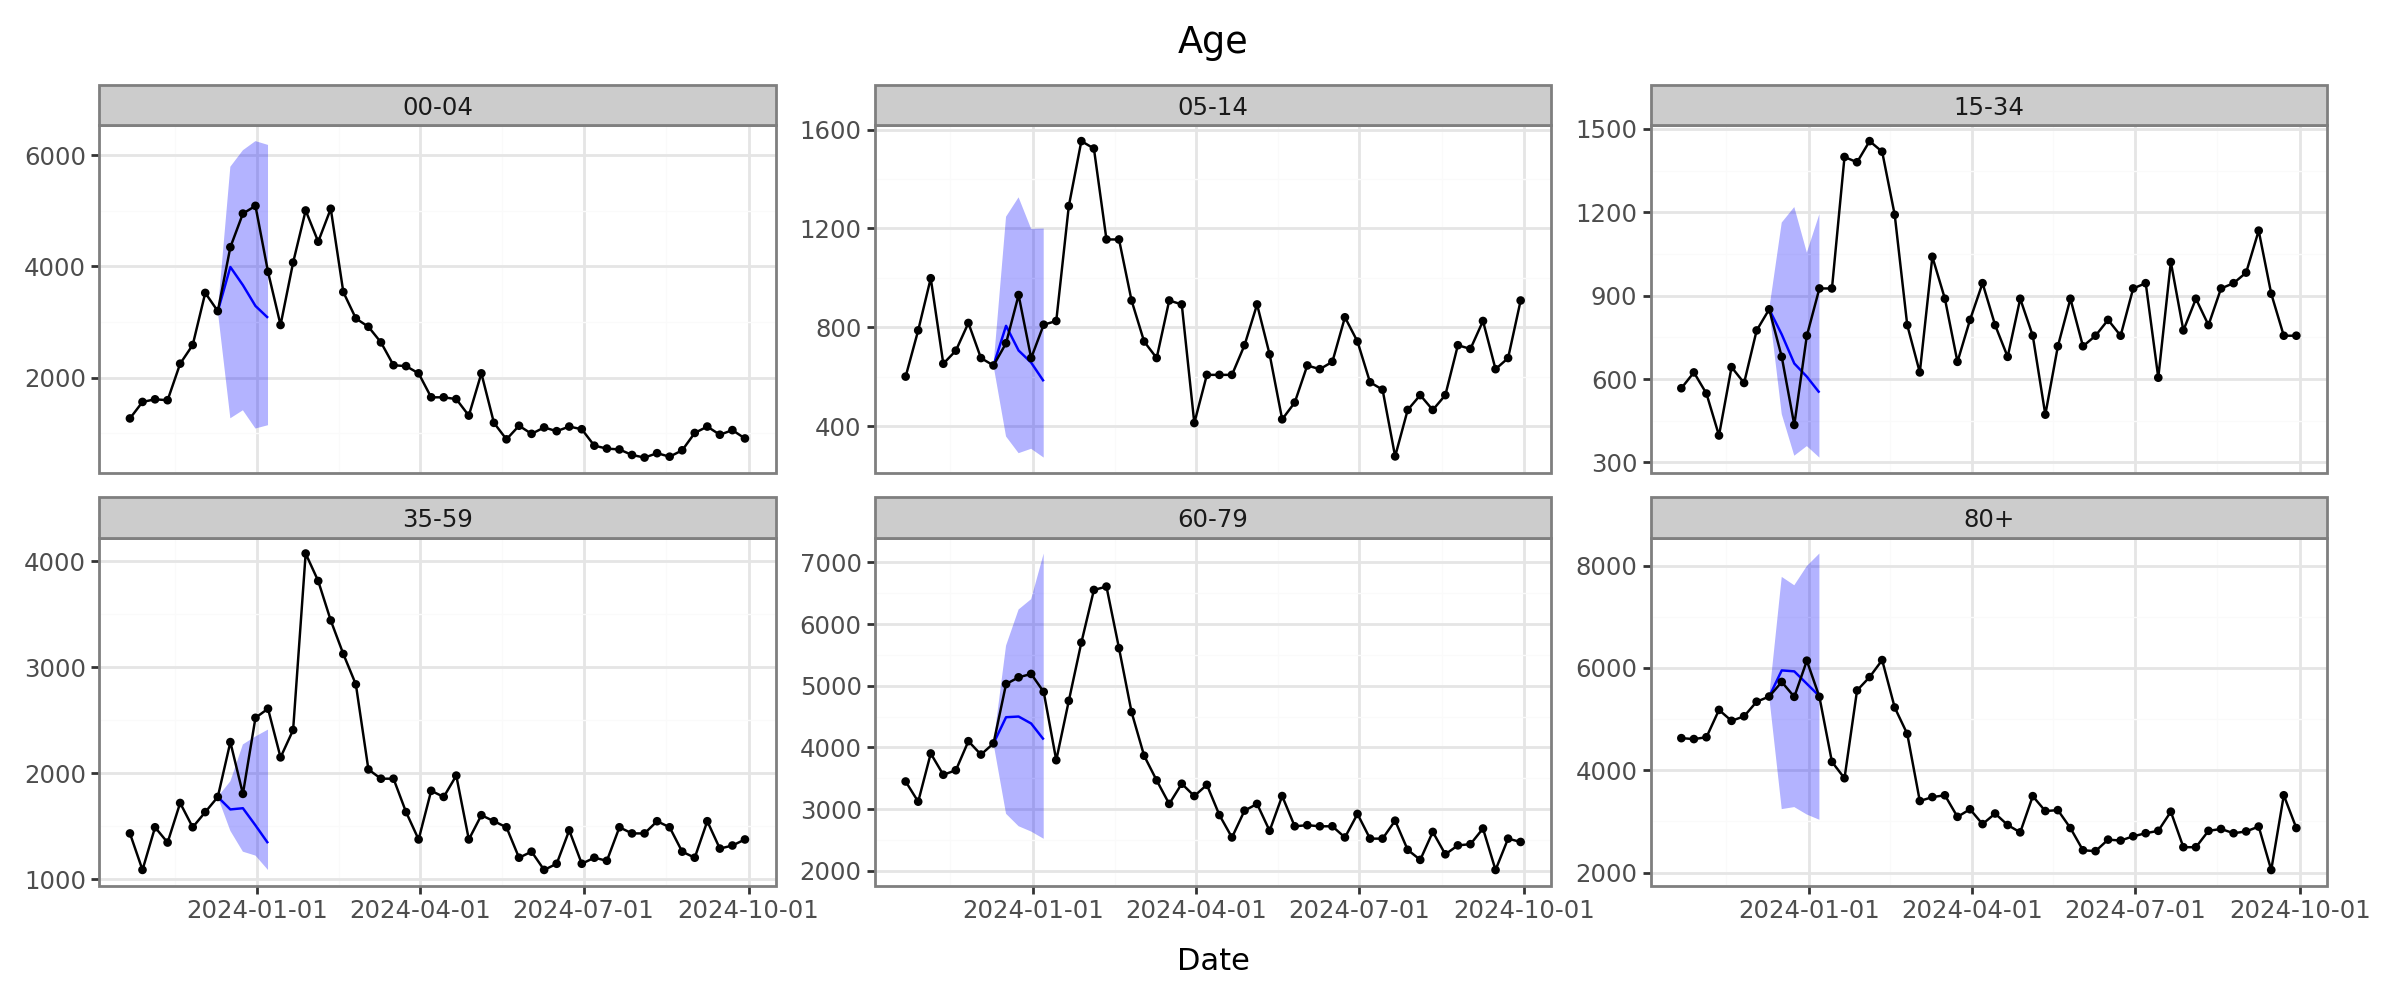

In [31]:
plot_forecasts(df_plot, 'age', start=0)

# Feature importance

In [63]:
seed = 1

In [64]:
model_path = f'../models/post-covid/post-covid_{NAME}-{seed}.pt'
model = LightGBMModel.load(model_path)

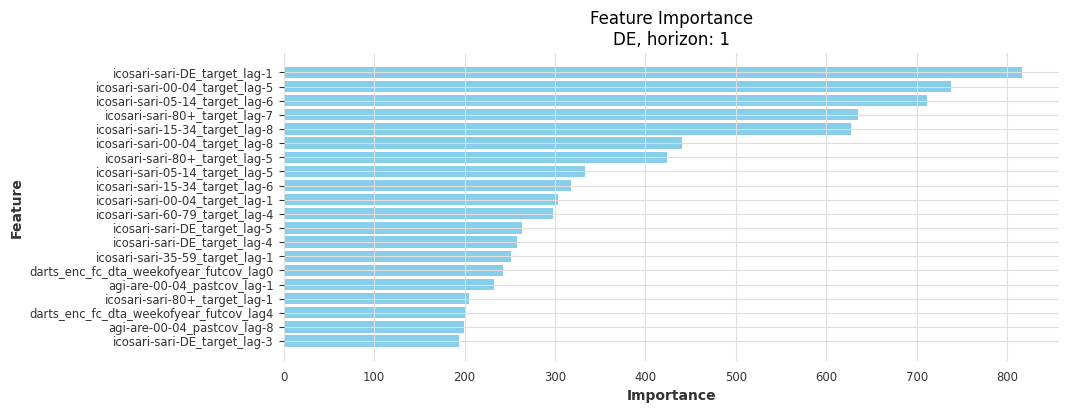

In [65]:
plot_importance_lgbm(model, horizon=1, max_features=20, y_size=4)

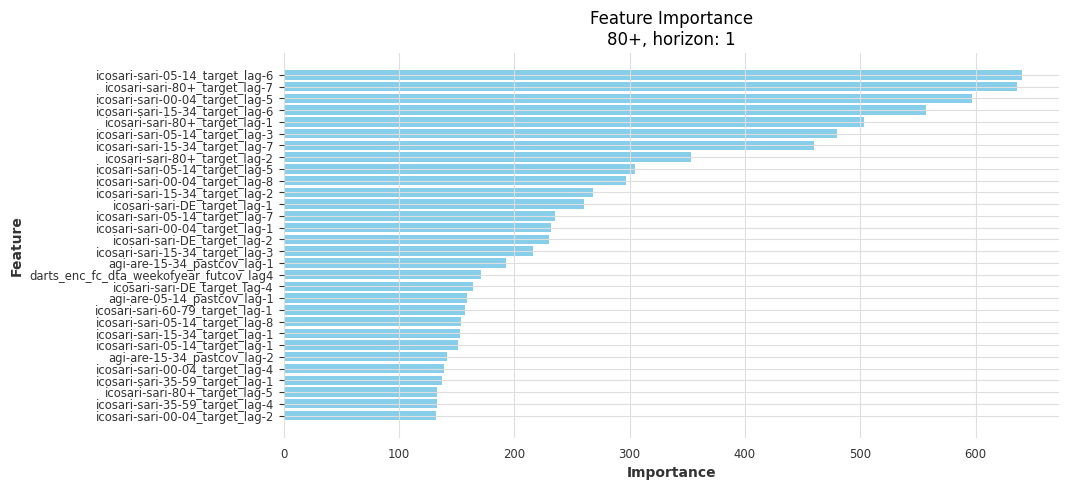

In [66]:
plot_importance_lgbm(model, age_group='80+', horizon=1, max_features=30, y_size=5)

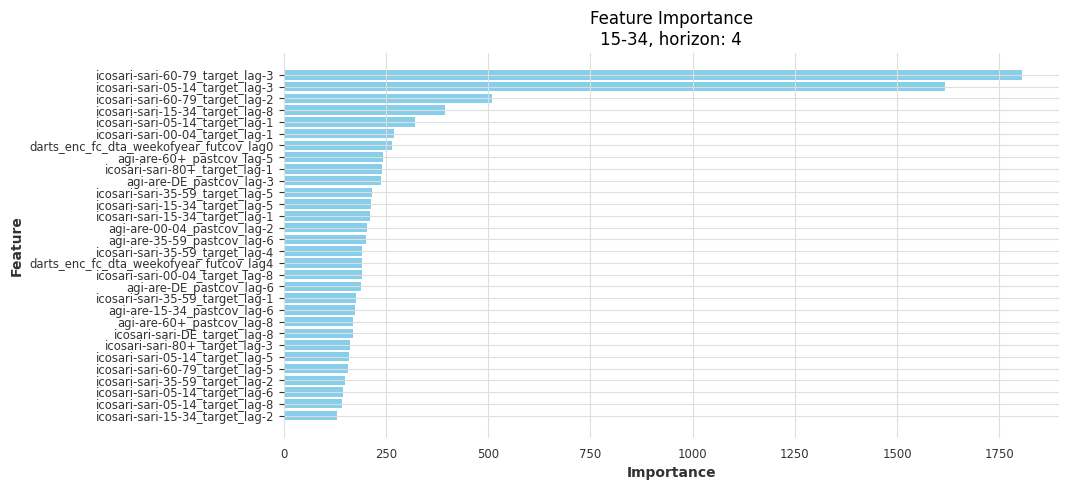

In [73]:
plot_importance_lgbm(model, age_group='15-34', horizon=4, max_features=30, y_size=5)